## 100 Runs for each ML Algorithm
- Run each model 100 times to get estimate of model performance
- Basically, we want to make a statement that the results we get in not merely due to change (lucky random number pick!), but indeed the results are repeatable
- Hence, we run the algorithm on 100 random partitions, one at a time

WARNING: Takes Hours to days of runtime  
GBRT takes the most time

Bidhya N Yadav  
Last Run (Feb, 2020)

In [1]:
%matplotlib inline

In [2]:
import math
import matplotlib.pyplot as plt

import os, sys, datetime
import numpy as np
import pandas as pd

from giuh_helpers import tic, toc

# Set a random seed so that experiment can be replicated
randomseed = 28
np.random.seed(randomseed)

In [3]:
# Using machine learning
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model
from sklearn import svm
from sklearn import ensemble

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold #KFold is changed
from sklearn.model_selection import GridSearchCV

cv = KFold(n_splits=10, shuffle=True,random_state=randomseed)

In [4]:
# Folder to save figures
fig_folder = 'journal_figs/velocity/100_runs'
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)
    
# Folder to save results
results_folder = 'results'
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# Part 1: Run each algorithm for 100 times

## Load saved data from csv file

In [5]:
# load data of regressors
df = pd.read_csv('data/velocity_regressors3.csv', index_col='site_no')
df.index = df.index.astype(str).str.zfill(8)
# Organize data in ascending order of correlation
ind = df.corr().VELOCITY.sort_values(ascending=False).index
df = df[ind]

In [6]:
data = df[['VELOCITY', 'SLOPE', 'WSAREA', 'ELEV', 'TMEAN', 'PRECIP', 'CLAY']] #, 'CLAY'
response = 'VELOCITY' #'vel_mean'# data = df[['slope', 'ElevWs', 'TmeanWs', 'cn', 'WtDepWs']]
y = data[response]
X = data.drop([response], axis=1)#.values

# Fit Each algorithm separately 
Save the training/test score and also merge them together

In [7]:
# Evaluate the impact of data splitting (Random seed)
def k_fold_val(grid, txt_lbl=None):
    random_seeds = np.arange(100)
    seed_dict = {}
    for random_seed in random_seeds:
        res = {}
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=random_seed)
        grid.fit(X_train, y_train)

        # Accurracy/error metrics
        model_name = grid.estimator.__repr__().split('(')[0]
        res['model'] = model_name
        res['val'] = grid.best_score_
        res['train'] = grid.score(X_train, y_train)
        res['test'] = grid.score(X_test, y_test)
        
        test_pred = grid.predict(X_test)
        res['RMSE'] = np.sqrt(metrics.mean_squared_error(y_test, test_pred))

        seed_dict[random_seed] = res
    # Convert to datafram
    seed_df = pd.DataFrame.from_dict(seed_dict, orient='index')
    seed_df.index.name = 'seed'

    seed_df.to_csv(f'{results_folder}/{model_name}.csv') #should always pick the max seed value
    return seed_df

In [ ]:
tic()
param_grid = {'n_estimators': np.arange(25, 301, 25)}
grid = GridSearchCV(ensemble.RandomForestRegressor(oob_score=True, random_state=randomseed), 
                    param_grid=param_grid, cv=cv, n_jobs=-1)
k_fold_val(grid, txt_lbl='d')  #d
toc()

In [ ]:
# Extra-Trees
param_grid = {'n_estimators': np.arange(25, 301, 25)}
grid = GridSearchCV(ensemble.ExtraTreesRegressor(min_samples_leaf = 2), param_grid=param_grid, cv=cv, n_jobs=-1)
k_fold_val(grid, txt_lbl='e')
toc()

In [11]:
# Elapsed time is 25.12 minutes. on ufhpc

---

# Part 2: Plotting only
So somewhat independed of part 1  
After Running everything above to get results in csv file

In [9]:
# Read all dataframes
models = ['ExtraTreesRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor']
df1 = pd.read_csv(f'results/{models[0]}.csv', index_col='seed')
df2 = pd.read_csv(f'results/{models[1]}.csv', index_col='seed')
df3 = pd.read_csv(f'results/{models[2]}.csv', index_col='seed')

# Concatenate results of all the ML algorithms together
df = pd.read_csv(f'results/{models[0]}.csv', index_col='seed') #Read one Dataframe
# Then read the remaining dataframes and concatenate to the first df
for model in models[1:]:
    temp_df = pd.read_csv('results/{}.csv'.format(model), index_col='seed')
    df = pd.concat([df, temp_df])
df = df[['train', 'test', 'RMSE', 'model']]

# To remove the regressor portion from model name
df['model'] = df['model'].apply(lambda x: x.split('Regressor')[0])
# Group by each of the models(ET, RF etc)
dfg = df.groupby('model', sort=False) #not sorted so original order of row index retained

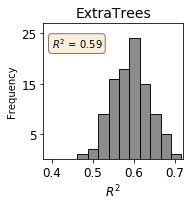

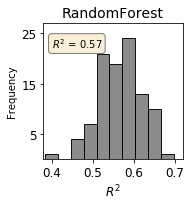

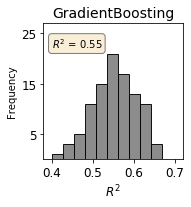

In [10]:
# Now plot the figures
for name, group in dfg:
    group[['test']].plot(kind='hist', bins=10, alpha=.9, edgecolor='k', legend=None, color='gray',
                         fontsize=12, figsize=(2.5,2.5))
    plt.title(name, fontsize=14)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(.40, 22, '$R^2$ = {:.2f}'.format(group['test'].mean()), bbox=props, fontsize=10, rotation=0)
    plt.xlabel('$R^2$', fontsize=12)
    plt.xlim([0.38, 0.72])
    plt.xticks([.40, .50, .60, .70])
    plt.ylim([0, 27])
    plt.yticks([5, 15, 25])
    
    #plt.savefig(fig_folder + '/{}'.format(name), transparent=True, bbox_inches='tight')